In this notebook, I will show how to train the TensorFlow version of Sketch-RNN on a new dataset, and convert the weights of the TF model to a JSON format that is usable by Sketch-RNN-JS so that interactive web demos can be built.

For the purpose of this tutorial, I will be training on the dataset file created by the other notebook in this repo that takes a raw quickdraw ndjson file and coverts it into npz stroke format. If you have a custom dataset, you will need to convert it over to an .npz file using the stroke-3 format as done for these datasets. Please study the README.md in Sketch-RNN to understand how the file format that Sketch-RNN can work with work, in the section called ["Creating Your Own Dataset"](https://github.com/tensorflow/magenta/blob/master/magenta/models/sketch_rnn/README.md).

After cloning the TensorFlow repo for the Sketch-RNN [model](https://github.com/tensorflow/magenta/tree/master/magenta/models/sketch_rnn), below is the command that I ran to train the TensorFlow model:

```
python sketch_rnn_train.py --data_dir=quickdraw --gpu=0 --log_root=log_toilet_2 --hparams=data_set=['mountain.200.npz'],num_steps=1000000,conditional=0,dec_rnn_size=1024,recurrent_dropout_prob=0.85
```

I had the `toilet.200.npz` inside the subdirectory called `quickdraw` but you can use whatever you want. The important thing to note here is that I'm trainining a decoder-only model by setting `conditional=0` and I'm training a 1 layer LSTM with hidden size of 1024, which should be good enough for most datasets in the order of 10K size. Using 200K steps should take around half a day on a single P100 GPU, so it should cost around USD 10 dollars using the current prices for Google Cloud Platform to train this model.

After the model is trained, I run the remaining commands for this IPython notebook to generate a file call `toilet.gen.json`, which can be used in the Sketch-RNN-JS repo for interactive work:

https://github.com/tensorflow/magenta-demos/tree/master/sketch-rnn-js

This `json` format created will also work for future TensorFlow.js and ML5.js versions of sketch-RNN.

In [175]:
# import the required libraries
import numpy as np
import time
import random

import codecs
import collections
import os
import math
import json
import tensorflow as tf
from six.moves import xrange

# libraries required for visualisation:
from IPython.display import SVG, display
import svgwrite # conda install -c omnia svgwrite=1.1.6
import PIL
from PIL import Image
import matplotlib.pyplot as plt

# set numpy output to something sensible
np.set_printoptions(precision=8, edgeitems=6, linewidth=200, suppress=True)

In [176]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [177]:
tf.logging.info("TensorFlow Version: %s", tf.__version__)


INFO:tensorflow:TensorFlow Version: 1.15.2


In [178]:
# import our command line tools
'''
from magenta.models.sketch_rnn.sketch_rnn_train import *
from magenta.models.sketch_rnn.model import *
from magenta.models.sketch_rnn.utils import *
from magenta.models.sketch_rnn.rnn import *
'''

# If code is modified to remove magenta dependencies:
from sketch_rnn_train import *
from model import *
from utils import *
from rnn import *

In [179]:
# little function that displays vector images and saves them to .svg
def draw_strokes(data, factor=0.2, svg_filename = '/tmp/sketch_rnn/svg/sample.svg'):
  tf.gfile.MakeDirs(os.path.dirname(svg_filename))
  min_x, max_x, min_y, max_y = get_bounds(data, factor)
  dims = (50 + max_x - min_x, 50 + max_y - min_y)
  dwg = svgwrite.Drawing(svg_filename, size=dims)
  dwg.add(dwg.rect(insert=(0, 0), size=dims,fill='white'))
  lift_pen = 1
  abs_x = 25 - min_x 
  abs_y = 25 - min_y
  p = "M%s,%s " % (abs_x, abs_y)
  command = "m"
  for i in xrange(len(data)):
    if (lift_pen == 1):
      command = "m"
    elif (command != "l"):
      command = "l"
    else:
      command = ""
    x = float(data[i,0])/factor
    y = float(data[i,1])/factor
    lift_pen = data[i, 2]
    p += command+str(x)+","+str(y)+" "
  the_color = "black"
  stroke_width = 1
  dwg.add(dwg.path(p).stroke(the_color,stroke_width).fill("none"))
  dwg.save()
  display(SVG(dwg.tostring()))

# generate a 2D grid of many vector drawings
def make_grid_svg(s_list, grid_space=10.0, grid_space_x=16.0):
  def get_start_and_end(x):
    x = np.array(x)
    x = x[:, 0:2]
    x_start = x[0]
    x_end = x.sum(axis=0)
    x = x.cumsum(axis=0)
    x_max = x.max(axis=0)
    x_min = x.min(axis=0)
    center_loc = (x_max+x_min)*0.5
    return x_start-center_loc, x_end
  x_pos = 0.0
  y_pos = 0.0
  result = [[x_pos, y_pos, 1]]
  for sample in s_list:
    s = sample[0]
    grid_loc = sample[1]
    grid_y = grid_loc[0]*grid_space+grid_space*0.5
    grid_x = grid_loc[1]*grid_space_x+grid_space_x*0.5
    start_loc, delta_pos = get_start_and_end(s)

    loc_x = start_loc[0]
    loc_y = start_loc[1]
    new_x_pos = grid_x+loc_x
    new_y_pos = grid_y+loc_y
    result.append([new_x_pos-x_pos, new_y_pos-y_pos, 0])

    result += s.tolist()
    result[-1][2] = 1
    x_pos = new_x_pos+delta_pos[0]
    y_pos = new_y_pos+delta_pos[1]
  return np.array(result)

define the path of the model you want to load, and also the path of the dataset

In [282]:
# you may need to change these to link to where your data and checkpoints are actually stored!
# in the default config, model_dir is likely to be /tmp/sketch_rnn/models
data_dir = './quickdraw'
model_dir = './log_toilet_2'

In [283]:
[train_set, valid_set, test_set, hps_model, eval_hps_model, sample_hps_model] = load_env(data_dir, model_dir, inference_mode=False)

INFO:tensorflow:Loaded 124615/3000/2000 from toilet.200.npz
INFO:tensorflow:Dataset combined: 129615 (124615/3000/2000), avg len 122
INFO:tensorflow:model_params.max_seq_len 200.
total images <= max_seq_len is 124615
total images <= max_seq_len is 3000
total images <= max_seq_len is 2000
INFO:tensorflow:normalizing_scale_factor 22.4944.


In [284]:
[hps_model, eval_hps_model, sample_hps_model] = load_model(model_dir)

In [285]:
# construct the sketch-rnn model here:
reset_graph()
model = Model(hps_model)
eval_hps_model.is_training = 1
eval_hps_model.batch_size = 100
eval_model = Model(eval_hps_model, reuse=True)
sample_model = Model(sample_hps_model, reuse=True)

INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = False.
INFO:tensorflow:Output dropout mode = False.
INFO:tensorflow:Recurrent dropout mode = True.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.
INFO:tensorflow:Model using gpu.
INFO:tensorflow:Input dropout mode = 0.
INFO:tensorflow:Output dropout mode = 0.
INFO:tensorflow:Recurrent dropout mode = 0.


In [286]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [287]:
def decode(z_input=None, draw_mode=True, temperature=0.1, factor=0.2):
  z = None
  if z_input is not None:
    z = [z_input]
  sample_strokes, m = sample(sess, sample_model, seq_len=eval_model.hps.max_seq_len, temperature=temperature, z=z)
  strokes = to_normal_strokes(sample_strokes)
  if draw_mode:
    draw_strokes(strokes, factor)
  return strokes

In [288]:
# loads the weights from checkpoint into our model
load_checkpoint(sess, model_dir)

INFO:tensorflow:Loading model ./log_toilet_2/vector-274000.
INFO:tensorflow:Restoring parameters from ./log_toilet_2/vector-274000


In [289]:
def custom_evaluate_model(sess, model, data_set):
  """Returns the average weighted cost, reconstruction cost and KL cost."""
  total_cost = 0.0
  for batch in range(data_set.num_batches):
    unused_orig_x, x, s = data_set.get_batch(batch)
    feed = {model.input_data: x, model.sequence_lengths: s}
    cost = sess.run([model.cost], feed)
    total_cost += cost[0]

  total_cost /= (data_set.num_batches)

  return total_cost

In [290]:
print("validation loss", custom_evaluate_model(sess, eval_model, valid_set))
print("test loss", custom_evaluate_model(sess, eval_model, test_set))

validation loss -1.1471562077601751
test loss -1.1537563502788544


In [319]:
# randomly unconditionally generate 10 examples
N = 6
M = 4
reconstructions = []
for j in range(M):
  for i in range(N):
    reconstructions.append([decode(temperature=0.5, draw_mode=False), [j, i]])

Let's see if our model kind of works by sampling from it:

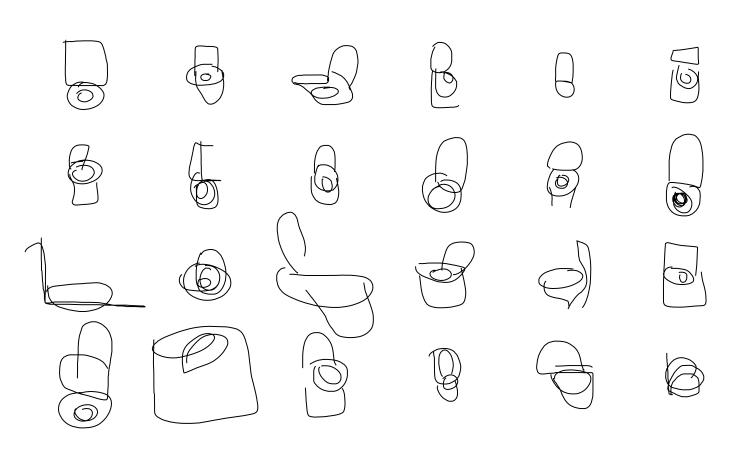

In [320]:
stroke_grid = make_grid_svg(reconstructions, grid_space=20.0, grid_space_x=24.0)
draw_strokes(stroke_grid, svg_filename="sample_toilet.svg")

In [302]:
def get_model_params():
  # get trainable params.
  model_names = []
  model_params = []
  model_shapes = []
  with sess.as_default():
    t_vars = tf.trainable_variables()
    for var in t_vars:
      param_name = var.name
      p = sess.run(var)
      model_names.append(param_name)
      params = p
      model_params.append(params)
      model_shapes.append(p.shape)
  return model_params, model_shapes, model_names

def quantize_params(params, max_weight=10.0, factor=32767):
  result = []
  max_weight = np.abs(max_weight)
  for p in params:
    r = np.array(p)
    r /= max_weight
    r[r>1.0] = 1.0
    r[r<-1.0] = -1.0
    result.append(np.round(r*factor).flatten().astype(np.int).tolist())
  return result

In [303]:
model_params, model_shapes, model_names = get_model_params()

In [304]:
model_names

['vector_rnn/RNN/output_w:0',
 'vector_rnn/RNN/output_b:0',
 'vector_rnn/RNN/LSTMCell/W_xh:0',
 'vector_rnn/RNN/LSTMCell/W_hh:0',
 'vector_rnn/RNN/LSTMCell/bias:0']

In [305]:
# scale factor converts "model-coordinates" to "pixel coordinates" for your JS canvas demo later on.
# the larger it is, the larger your drawings (in pixel space) will be.
# I recommend setting this to 100.0 and iterating the value in the json file later on when you build the JS part.
scale_factor = 70.0
metainfo = {"mode":2,"version":6,"max_seq_len":train_set.max_seq_length,"name":"toilet","scale_factor":scale_factor}

In [306]:
model_params_quantized = quantize_params(model_params)

In [307]:
model_blob = [metainfo, model_shapes, model_params_quantized]

In [308]:
with open("toilet.gen.full.json", 'w') as outfile:
  json.dump(model_blob, outfile, separators=(',', ':'))

After you dump the `custom.gen.full.json`, you should save the below code as `compress_model.json`, and run:

```
node compress_model.js custom.gen.full.json custom.gen.json
```

To get to the final file you can use for Sketch-RNN-JS

Below is the entire code for `compress_model.js` which will be run using node:

```
/*
compress_model.js
Compress JSON model to b64 encoded version to save bandwidth. only works for decoder-only sketch-rnn model.
*/

const assert = require('assert');
const fs = require('fs');

/**
 * deals with decompressing b64 models to float arrays.
 */
function btoa(s) {
  return Buffer.from(s, 'binary').toString('base64');
}
function string_to_uint8array(b64encoded) {
  var u8 = new Uint8Array(atob(b64encoded).split("").map(function(c) {
    return c.charCodeAt(0); }));
  return u8;
}
function uintarray_to_string(u8) {
  var s = "";
  for (var i = 0, len = u8.length; i < len; i++) {
    s += String.fromCharCode(u8[i]);
  }
  var b64encoded = btoa(s);
  return b64encoded;
};
function string_to_array(s) {
  var u = string_to_uint8array(s);
  var result = new Int16Array(u.buffer);
  return result;
};
function array_to_string(a) {
  var u = new Uint8Array(a.buffer);
  var result = uintarray_to_string(u);
  return result;
};

var args = process.argv.slice(2);

try {
  assert.strictEqual(args.length, 2);
} catch (err) {
  console.log("Usage: node compress_model.js orig_full_model.json compressed_model.json")
  process.exit(1);
}

var orig_file = args[0];
var target_file = args[1];

var orig_model = JSON.parse(fs.readFileSync(orig_file, 'ascii'));

var model_weights = orig_model[2];
var compressed_weights = [];

for (var i=0;i<model_weights.length;i++) {
  compressed_weights.push(array_to_string(new Int16Array(model_weights[i])));
}

var target_model = [orig_model[0], orig_model[1], compressed_weights];

fs.writeFileSync(target_file, JSON.stringify(target_model), 'ascii');
```